## Integration by Interpolation ##

We want to use a NN to compute the integral $I$ of a polynomial function in the form of: 

$$I = \int_{0}^{B} (αx^2 + βx + γ)\, dx \, \Longrightarrow$$ 
$$ = \frac{α}{3}B^3 + \frac{β}{2}B^2 + γB $$ 

In [1]:
# Command
%load_ext autoreload
%autoreload 2

# Modules 
import sys
sys.path.insert(0, '/home/lsantiago/workspace/ic/project/')
import os
import numpy as np
import torch
from src import nn_architecture as NN
from src import model_training as mt
from src import generic as gc
from src.generate_poly_dataset import PolyDataset, ToTensor
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

# Paths
working_path = sys.path[0]
path_to_data = os.path.join(working_path, 'data')
path_to_models = os.path.join(working_path, 'models')
path_to_images = os.path.join(working_path, 'images')
data = os.path.join(path_to_data, 'poly_data.npy')

# Parameters
torch.set_default_dtype(torch.float64)

Model and training parameters

In [2]:
batch_size = 100
lr = 0.001
epochs = 500
n_sample = 100000
full_data = False

Get and split dataset

In [3]:
poly_data = np.load(data) # Load polynomials numpy array
mean = np.mean(poly_data, axis=0)
y_mean = mean[-1]
X_mean = mean[:-1]
std = np.std(poly_data, axis=0)
y_std = std[-1]
X_std = std[:-1]
poly_data_norm = (poly_data - mean)/std
poly_data = poly_data_norm # Normalizing data

# poly_data[:, -2] = 1 # Fixing limit of integration
poly_data = poly_data.astype(np.float64)
if not full_data:
    poly_data = poly_data[:n_sample]
poly_data = poly_data[:, :-1], poly_data[:, -1]
data_size = len(poly_data[0]) if not full_data else None
transformed_dataset = PolyDataset(poly_data, transform=ToTensor())
X, y = transformed_dataset.data
print(X.shape, y.shape)

training_data, test_data = gc.split_dataset(transformed_dataset, seed=42)

(100000, 4) (100000,)


Create data loaders

In [4]:
train_dataloader = DataLoader(training_data,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(test_data, 
                             batch_size=batch_size,
                             shuffle=True)

for X, y in test_dataloader:
    print(f'Shape of X [α, β, γ, B]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of X [α, β, γ, B]: torch.Size([100, 4])
Shape of y: torch.Size([100]) torch.float64


Define NN architecture

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = NN.NeuralNetwork().to(device)
nodes_config = NN.nodes_config
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=40, bias=True)
    (7): ReLU()
    (8): Linear(in_features=40, out_features=40, bias=True)
    (9): ReLU()
    (10): Linear(in_features=40, out_features=40, bias=True)
    (11): ReLU()
    (12): Linear(in_features=40, out_features=40, bias=True)
    (13): ReLU()
    (14): Linear(in_features=40, out_features=1, bias=True)
  )
)


In [6]:
# Count model parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

10081


Defining model

In [7]:
# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Get model name

In [8]:
if full_data:
    data_size = None
model_name = gc.get_model_name(nodes_config, batch_size, lr, epochs, data_size)
plot_path = os.path.join(path_to_images, model_name)

Train/test the model

In [9]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0
-------------------------
Test error: 
 Performance 9.9214e-03, Avg train loss: 1.055092e+00, Avg test loss: 9.899410e-01 

Epoch 1
-------------------------
Test error: 
 Performance 9.9159e-03, Avg train loss: 1.284524e+00, Avg test loss: 9.893016e-01 

Epoch 2
-------------------------
Test error: 
 Performance 9.9115e-03, Avg train loss: 1.237011e+00, Avg test loss: 9.885931e-01 

Epoch 3
-------------------------
Test error: 
 Performance 9.9091e-03, Avg train loss: 8.558919e-01, Avg test loss: 9.878399e-01 

Epoch 4
-------------------------
Test error: 
 Performance 9.9031e-03, Avg train loss: 9.135745e-01, Avg test loss: 9.869285e-01 

Epoch 5
-------------------------
Test error: 
 Performance 9.8976e-03, Avg train loss: 1.112439e+00, Avg test loss: 9.860563e-01 

Epoch 6
-------------------------
Test error: 
 Performance 9.8985e-03, Avg train loss: 1.037028e+00, Avg test loss: 9.851222e-01 

Epoch 7
-------------------------
Test error: 
 Performance 9.8900e-03, Avg 

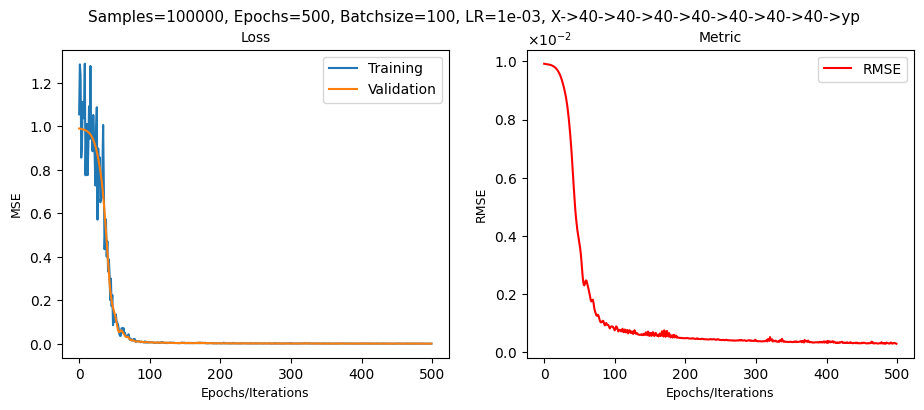

In [10]:
tl = []
vl = []
acc = []
early_stopper = EarlyStopper(patience=5, min_delta=1e-2)
for t in tqdm(range(epochs)):
    train_loss = mt.train(train_dataloader, model, loss_fn, optimizer)
    test_loss, metric = mt.test(train_dataloader, model, loss_fn)
    tl.append(train_loss)
    vl.append(test_loss)
    acc.append(metric)
    if t % 1 == 0:
        print(f"Epoch {t}\n-------------------------")
        print(f"Test error: \n Performance {(metric):>0.4e}, Avg train loss: {train_loss:>8e}, Avg test loss: {test_loss:>8e} \n")
    if early_stopper.early_stop(test_loss):             
        break
print("Done!\n")

plots = gc.plot_performance(train_loss=tl, test_loss=vl, accuracy=acc, model_name=model_name)
# plt.savefig(f"{plot_path}.png")
print(f"For training: \n Max RMSE {(np.array(acc).max()):>0.4e}, Max loss: {np.array(test_loss).max():>8e} \n")
plt.show()

Save model

In [17]:
plt.savefig(f"{plot_path}.png")

<Figure size 640x480 with 0 Axes>

In [18]:
torch.save(model.state_dict(), os.path.join(path_to_models, model_name))

In [13]:
X_n, y_n = poly_data[0], poly_data[1]
y = y_n*y_std + y_mean
y_pred_n = model(torch.atleast_2d(torch.tensor(X_n))).detach().numpy().squeeze()
y_pred = y_pred_n*y_std + y_mean
y_train_n = training_data[:][1]
y_train = y_train_n*y_std + y_mean
y_test_n = test_data[:][1]
y_test = y_test_n*y_std + y_mean
error = (np.abs(y_pred - y) < 0.1*y).sum() / len(y)
print(f'{error:.2%}')


84.95%


In [14]:
a = gc.compute_integral(([0, 0, 1, 1]))
b = model(torch.atleast_2d(torch.tensor(gc.normalize([0, 0, 1, 1], X_mean, X_std), dtype=torch.float64)))
b = gc.unnormalize(b.item(),y_mean, y_std,)
outs = [a,
      b,
      ((a - b)/a).item()]

outs = list(map(lambda x: f'{x:.3f}', outs))
outs[-1] = f'{float(outs[-1]):.1%}'
outs
print(*outs, '\n')

1.000 1.014 -1.4% 



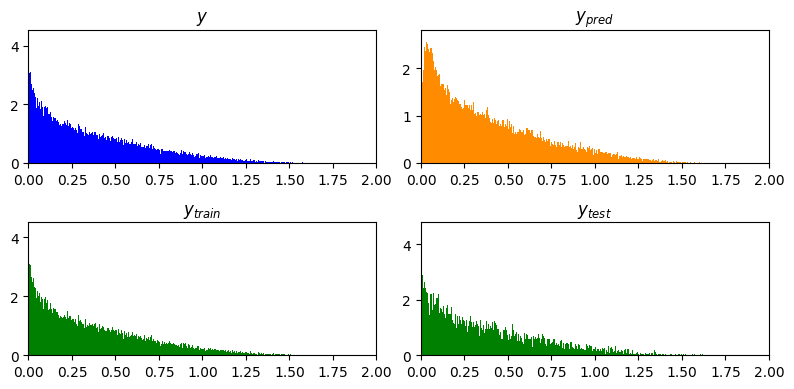

In [15]:
fig, ax = plt.subplots(2,2, figsize=(8,4))
ax[0, 0].hist(y, bins=1000, label='y', color='blue', density=True)
ax[0, 0].set_xlim([0, 2])
ax[0, 0].set_title(f'$y$')
ax[0, 1].hist(y_pred, bins=1000, label='y_pred', color='darkorange', density=True)
ax[0, 1].set_xlim([0, 2])
ax[0, 1].set_title(f'$y_{{pred}}$')
ax[1, 0].hist(y_train, bins=1000, label='y_train', color='green', density=True)
ax[1, 0].set_xlim([0, 2])
ax[1, 0].set_title(f'$y_{{train}}$')
ax[1, 1].hist(y_test, bins=1000, label='y_test', color='green', density=True)
ax[1, 1].set_xlim([0, 2])
ax[1, 1].set_title(f'$y_{{test}}$')

fig.tight_layout()
plt.show()

In [16]:
a = gc.compute_integral(([0.8, 0.2, 0.1, 1]))
b = model(torch.atleast_2d(torch.tensor(gc.normalize([0.8, 0.2, 0.1, 1], X_mean, X_std), dtype=torch.float64)))
b = gc.unnormalize(b.item(),y_mean, y_std,)
outs = [a,
      b,
      ((a - b)/a).item()]

outs = list(map(lambda x: f'{x:.3f}', outs))
outs[-1] = f'Relative error: {float(outs[-1]):.1%}'
outs
print(*outs, '\n')

0.467 0.459 Relative error: 1.7% 

